<a href="https://colab.research.google.com/github/nlpproject65-netizen/clearspeak-api/blob/main/Copy_of_02_complete_data_pipeline_days2to7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CLEARSPEAK: COMPLETE DATA PIPELINE (Days 2-7)
Indian English Text Simplification - 558 CLEANED Examples
Mounted at /content/drive
✅ Setup complete

DAYS 2-3: DATA COLLECTION & LOADING

📁 Upload your CSV file:
Expected: IndianEnglish-Simplification-Dataset-v1-Sheet2.csv



Saving IndianEnglish-Simplification-Dataset-v1 - Sheet2.csv to IndianEnglish-Simplification-Dataset-v1 - Sheet2.csv
✅ File saved to: /content/drive/MyDrive/ClearSpeak/data/raw/IndianEnglish-Simplification-Dataset-v1 - Sheet2.csv

📊 Dataset loaded successfully!
   Initial shape: (559, 5)
   Initial columns: ['Complex', 'Simple', 'Column 3', 'Column 4', 'Column 1']
   After cleanup: (559, 2)
   Final columns: ['Complex', 'Simple']

DAYS 4-5: DATA EXPLORATION & VALIDATION

1️⃣ Checking data quality...

📋 Missing values:
   Complex: 0
   Simple: 0

🔍 Duplicate pairs: 1

📊 Dataset statistics:
   Unique complex sentences: 555
   Unique simple sentences: 556
   Total pairs loaded: 559

DAYS 6-7: TEXT PREPROCESSING

🧹 Cleaning all text...
✅ Text cleaned! Remaining examples: 559 pairs

2️⃣ Calculating complexity metrics...

📏 Length Statistics:
   Complex sentences:
      Average: 47.2 words
      Min: 7, Max: 292

   Simple sentences:
      Average: 31.4 words
      Min: 6, Max: 184

   Reduct

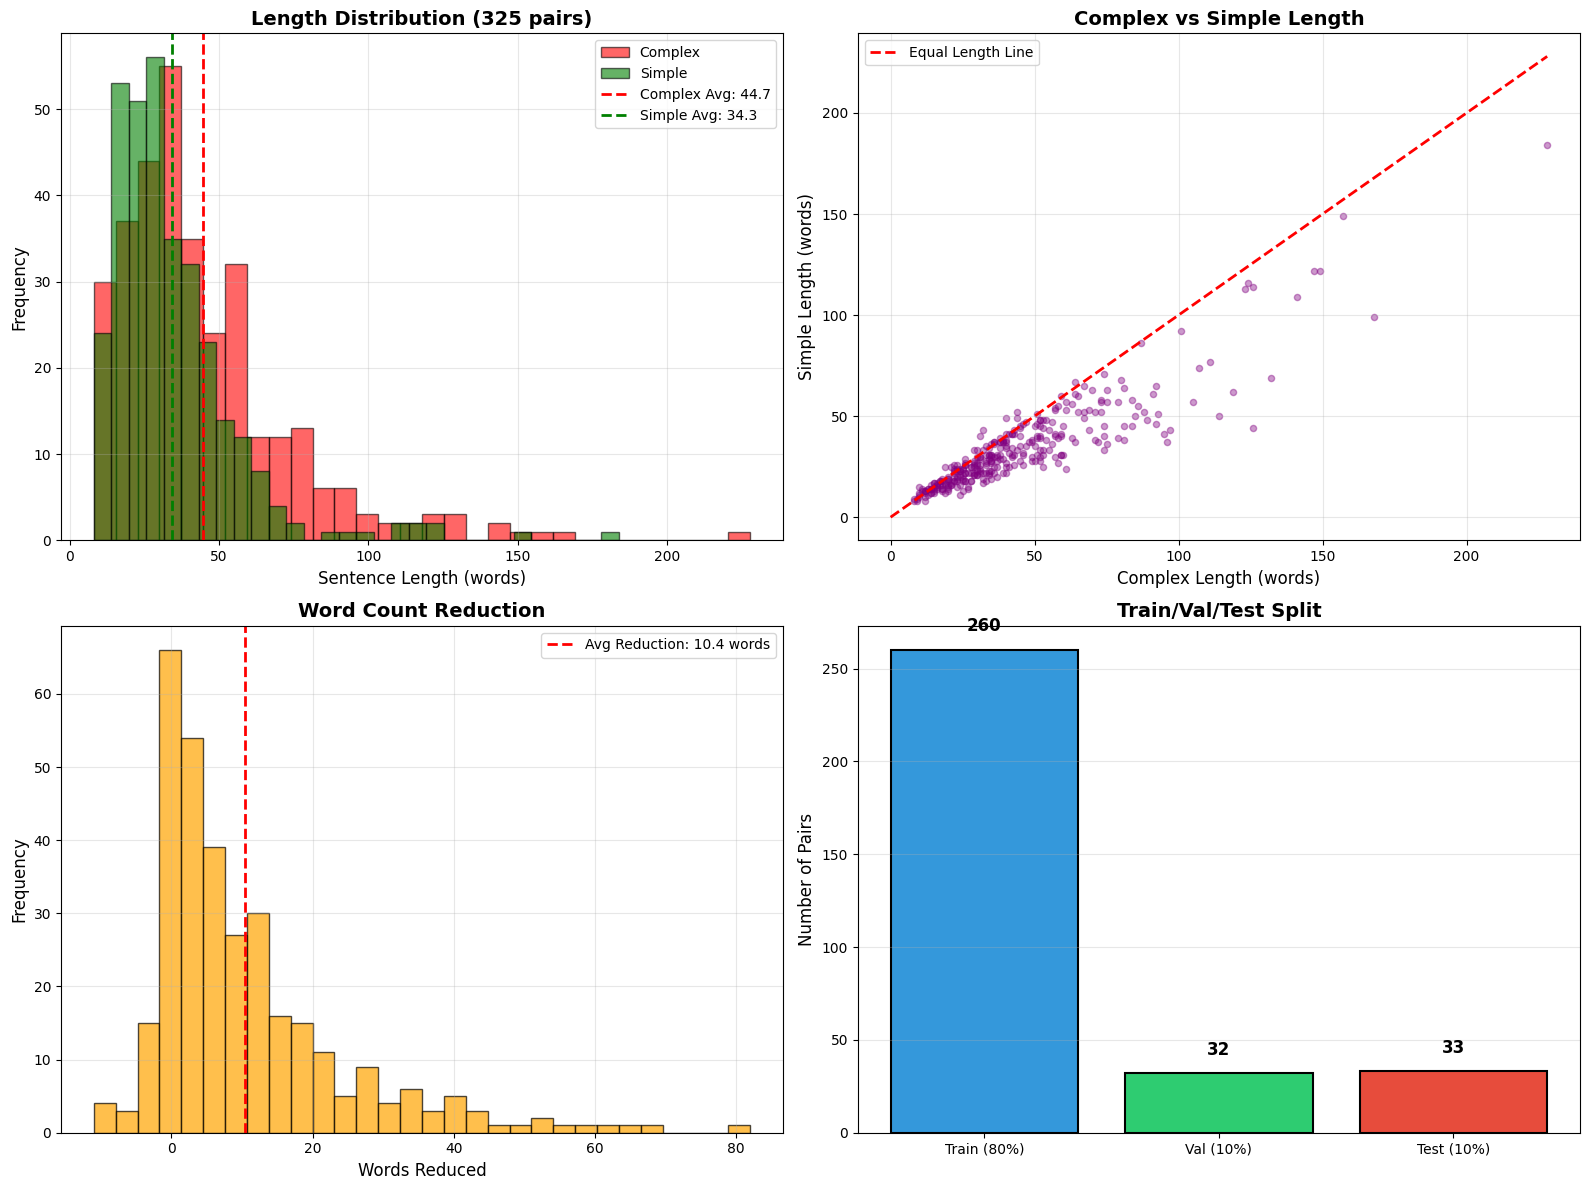


🎯 PHASE 1 COMPLETE: DAYS 2-7 SUMMARY

╔══════════════════════════════════════════════════════════════════════╗
║           CLEARSPEAK - PHASE 1 DATA PIPELINE SUMMARY                 ║
╚══════════════════════════════════════════════════════════════════════╝


📊 DAYS 2-3: DATA COLLECTION
   ✅ Loaded: 558 CLEANED Indian English examples
   ✅ Dataset: IndianEnglish-Simplification-Dataset-v1-Sheet2.csv
   ✅ All problematic rows (40) ALREADY REMOVED


🔍 DAYS 4-5: DATA EXPLORATION
   ✅ Initial examples: 558
   ✅ After cleaning: 559 pairs
   ✅ After validation: 325 pairs


   📏 Complexity Metrics:
      • Complex sentences: 44.7 words (avg)
      • Simple sentences: 34.3 words (avg)
      • Word reduction: 10.4 words (18.1%)


🧹 DAYS 6-7: TEXT PREPROCESSING & FILTERING
   ✅ Text cleaning applied
   ✅ Quality filtering (30% overlap minimum)
   ✅ Removed 2 duplicate pairs
   ✅ T5 format: "simplify: <text>" → "<target>"


📦 FINAL DATASETS (READY FOR TRAINING):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# ========================================
# CLEARSPEAK: COMPLETE DATA PIPELINE (PHASE 1: DAYS 2-7)
# Adapted for 558-Example Indian Dataset (CLEANED)
# File: 01_complete_data_pipeline.ipynb
# ========================================

print("=" * 80)
print("CLEARSPEAK: COMPLETE DATA PIPELINE (Days 2-7)")
print("Indian English Text Simplification - 558 CLEANED Examples")
print("=" * 80)


from google.colab import drive
drive.mount('/content/drive')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


# Setup paths
BASE = "/content/drive/MyDrive/ClearSpeak"


import os
os.makedirs(f"{BASE}/data/raw", exist_ok=True)
os.makedirs(f"{BASE}/data/processed", exist_ok=True)
os.makedirs(f"{BASE}/data/visualizations", exist_ok=True)


# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)


print("✅ Setup complete\n")


# ========================================
# CELL 2: LOAD YOUR 558-EXAMPLE DATASET
# ========================================
print("=" * 80)
print("DAYS 2-3: DATA COLLECTION & LOADING")
print("=" * 80)


from google.colab import files


print("\n📁 Upload your CSV file:")
print("Expected: IndianEnglish-Simplification-Dataset-v1-Sheet2.csv\n")


# Upload file
uploaded = files.upload()
uploaded_filename = list(uploaded.keys())[0]


# Move to Drive
import shutil
source = f"/content/{uploaded_filename}"
dest = f"{BASE}/data/raw/{uploaded_filename}"
shutil.copy(source, dest)


print(f"✅ File saved to: {dest}\n")


# Load dataset
df = pd.read_csv(dest)


# ========================================
# HANDLE COLUMN NAMES (YOUR DATASET HAS UNNAMED COLUMNS)
# ========================================
print(f"📊 Dataset loaded successfully!")
print(f"   Initial shape: {df.shape}")
print(f"   Initial columns: {list(df.columns)}")


# Rename to standardize column names
# Your dataset has: ['Complex', 'Simple', 'Column 3', 'Column 4', 'Column 1']
df = df[['Complex', 'Simple']].copy()  # Keep only needed columns


print(f"   After cleanup: {df.shape}")
print(f"   Final columns: {list(df.columns)}")


# ========================================
# CELL 3: DATA VALIDATION & CLEANING
# ========================================
print("\n" + "=" * 80)
print("DAYS 4-5: DATA EXPLORATION & VALIDATION")
print("=" * 80)


print("\n1️⃣ Checking data quality...")


# Check for missing values
print(f"\n📋 Missing values:")
print(f"   Complex: {df['Complex'].isnull().sum()}")
print(f"   Simple: {df['Simple'].isnull().sum()}")


# Check for duplicates
before_dedup_total = len(df)
duplicates = df.duplicated(subset=['Complex', 'Simple']).sum()
print(f"\n🔍 Duplicate pairs: {duplicates}")


# Show data distribution
print(f"\n📊 Dataset statistics:")
print(f"   Unique complex sentences: {df['Complex'].nunique()}")
print(f"   Unique simple sentences: {df['Simple'].nunique()}")
print(f"   Total pairs loaded: {len(df)}")


# ========================================
# CELL 4: TEXT PREPROCESSING
# ========================================
print("\n" + "=" * 80)
print("DAYS 6-7: TEXT PREPROCESSING")
print("=" * 80)


def clean_text(text):
    """
    Clean text for T5 training
    - Remove extra spaces
    - Remove URLs and emails
    - Remove special characters (keep basic punctuation)
    - Convert to lowercase
    """
    text = str(text).strip()


    # Remove domain prefixes like "Banking |" if present
    if '|' in text:
        parts = text.split('|', 1)
        if len(parts) > 1:
            text = parts[1].strip()


    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)


    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)


    # Remove extra spaces
    text = ' '.join(text.split())


    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?\-\']', '', text)


    # Remove repeated punctuation
    text = re.sub(r'([.,!?]){2,}', r'\1', text)


    # Convert to lowercase
    text = text.lower().strip()


    return text


print("\n🧹 Cleaning all text...")


# Clean Complex and Simple columns
df['complex_clean'] = df['Complex'].apply(clean_text)
df['simple_clean'] = df['Simple'].apply(clean_text)


# Remove empty rows after cleaning
df = df[(df['complex_clean'].str.len() > 0) & (df['simple_clean'].str.len() > 0)]


print(f"✅ Text cleaned! Remaining examples: {len(df)} pairs")


# ========================================
# CELL 5: CALCULATE METRICS
# ========================================
print("\n2️⃣ Calculating complexity metrics...")


# Word lengths
df['complex_words'] = df['complex_clean'].apply(lambda x: len(x.split()))
df['simple_words'] = df['simple_clean'].apply(lambda x: len(x.split()))
df['word_reduction'] = df['complex_words'] - df['simple_words']
df['reduction_pct'] = ((df['complex_words'] - df['simple_words']) / df['complex_words'] * 100).round(1)


print(f"\n📏 Length Statistics:")
print(f"   Complex sentences:")
print(f"      Average: {df['complex_words'].mean():.1f} words")
print(f"      Min: {df['complex_words'].min()}, Max: {df['complex_words'].max()}")


print(f"\n   Simple sentences:")
print(f"      Average: {df['simple_words'].mean():.1f} words")
print(f"      Min: {df['simple_words'].min()}, Max: {df['simple_words'].max()}")


print(f"\n   Reduction:")
print(f"      Average: {df['word_reduction'].mean():.1f} words ({df['reduction_pct'].mean():.1f}%)")


# ========================================
# CELL 6: QUALITY FILTERING
# ========================================
print("\n3️⃣ Filtering quality pairs...")


def is_valid_pair(row):
    """
    Quality filters:
    1. Complex must be longer than simple (or equal)
    2. Minimum 30% word overlap
    3. Minimum lengths: complex >= 5 words, simple >= 3 words
    4. Simple cannot be longer than 1.2x complex length
    """
    complex_set = set(row['complex_clean'].split())
    simple_set = set(row['simple_clean'].split())


    # Minimum length check
    if len(complex_set) < 5 or len(simple_set) < 3:
        return False


    # Overlap check (30% minimum)
    overlap = len(complex_set & simple_set) / len(complex_set) if len(complex_set) > 0 else 0
    if overlap < 0.3:
        return False


    # Simple shouldn't be much longer than complex
    if len(simple_set) / len(complex_set) > 1.2:
        return False


    return True


df['is_valid'] = df.apply(is_valid_pair, axis=1)
valid_count = df['is_valid'].sum()
invalid_count = len(df) - valid_count


print(f"   Valid pairs: {valid_count}")
print(f"   Invalid pairs: {invalid_count}")


# Keep only valid pairs
df_filtered = df[df['is_valid']].copy()


print(f"✅ Filtering complete! Kept: {len(df_filtered)} pairs")


# ========================================
# CELL 7: REMOVE DUPLICATES
# ========================================
print("\n4️⃣ Removing duplicates...")


before_dedup = len(df_filtered)
df_filtered = df_filtered.drop_duplicates(subset=['complex_clean', 'simple_clean'], keep='first')
after_dedup = len(df_filtered)


print(f"   Duplicates removed: {before_dedup - after_dedup}")
print(f"✅ Final dataset: {len(df_filtered)} UNIQUE pairs")


# ========================================
# CELL 8: FORMAT FOR T5 TRAINING
# ========================================
print("\n" + "=" * 80)
print("FORMATTING FOR T5 MODEL")
print("=" * 80)


# T5 expects "simplify: <complex text>" as input
# And "<simple text>" as target


df_filtered['input_text'] = 'simplify: ' + df_filtered['complex_clean']
df_filtered['target_text'] = df_filtered['simple_clean']


print(f"\n✅ T5 format applied:")
print(f"   Input format: 'simplify: <complex text>'")
print(f"   Target format: '<simple text>'")


print(f"\n📝 Sample pair:")
print(f"   Input:  {df_filtered.iloc[0]['input_text'][:80]}...")
print(f"   Target: {df_filtered.iloc[0]['target_text'][:80]}...")


# ========================================
# CELL 9: TRAIN/VAL/TEST SPLIT
# ========================================
print("\n" + "=" * 80)
print("CREATING TRAIN/VALIDATION/TEST SPLITS")
print("=" * 80)


# 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(
    df_filtered,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    shuffle=True
)


print(f"\n📊 Final Split (80/10/10):")
print(f"   Training:   {len(train_df):>4} pairs ({len(train_df)/len(df_filtered)*100:.1f}%)")
print(f"   Validation: {len(val_df):>4} pairs ({len(val_df)/len(df_filtered)*100:.1f}%)")
print(f"   Test:       {len(test_df):>4} pairs ({len(test_df)/len(df_filtered)*100:.1f}%)")
print(f"   {'─'*50}")
print(f"   TOTAL:      {len(df_filtered):>4} pairs")


# ========================================
# CELL 10: SAVE PROCESSED FILES
# ========================================
print("\n" + "=" * 80)
print("SAVING PROCESSED DATASETS")
print("=" * 80)


# Save train/val/test splits (T5 format)
train_df[['input_text', 'target_text']].to_csv(
    f"{BASE}/data/processed/train.csv",
    index=False
)


val_df[['input_text', 'target_text']].to_csv(
    f"{BASE}/data/processed/val.csv",
    index=False
)


test_df[['input_text', 'target_text']].to_csv(
    f"{BASE}/data/processed/test.csv",
    index=False
)


# Save full dataset with all metadata
df_filtered.to_csv(
    f"{BASE}/data/processed/full_dataset_with_metadata.csv",
    index=False
)


print(f"\n✅ All files saved:")
print(f"   📄 {BASE}/data/processed/train.csv")
print(f"   📄 {BASE}/data/processed/val.csv")
print(f"   📄 {BASE}/data/processed/test.csv")
print(f"   📄 {BASE}/data/processed/full_dataset_with_metadata.csv")


# ========================================
# CELL 11: CREATE VISUALIZATIONS
# ========================================
print("\n" + "=" * 80)
print("CREATING VISUALIZATIONS")
print("=" * 80)


fig, axes = plt.subplots(2, 2, figsize=(16, 12))


# 1. Length distribution
axes[0, 0].hist(df_filtered['complex_words'], bins=30, alpha=0.6, label='Complex', color='red', edgecolor='black')
axes[0, 0].hist(df_filtered['simple_words'], bins=30, alpha=0.6, label='Simple', color='green', edgecolor='black')
axes[0, 0].axvline(df_filtered['complex_words'].mean(), color='red', linestyle='--', linewidth=2, label=f'Complex Avg: {df_filtered["complex_words"].mean():.1f}')
axes[0, 0].axvline(df_filtered['simple_words'].mean(), color='green', linestyle='--', linewidth=2, label=f'Simple Avg: {df_filtered["simple_words"].mean():.1f}')
axes[0, 0].set_xlabel('Sentence Length (words)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title(f'Length Distribution ({len(df_filtered)} pairs)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)


# 2. Scatter: Complex vs Simple length
axes[0, 1].scatter(df_filtered['complex_words'], df_filtered['simple_words'], alpha=0.4, s=20, color='purple')
max_val = max(df_filtered['complex_words'].max(), df_filtered['simple_words'].max())
axes[0, 1].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Equal Length Line')
axes[0, 1].set_xlabel('Complex Length (words)', fontsize=12)
axes[0, 1].set_ylabel('Simple Length (words)', fontsize=12)
axes[0, 1].set_title('Complex vs Simple Length', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)


# 3. Word reduction histogram
axes[1, 0].hist(df_filtered['word_reduction'], bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(df_filtered['word_reduction'].mean(), color='red', linestyle='--', linewidth=2, label=f'Avg Reduction: {df_filtered["word_reduction"].mean():.1f} words')
axes[1, 0].set_xlabel('Words Reduced', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Word Count Reduction', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)


# 4. Split distribution
split_counts = [len(train_df), len(val_df), len(test_df)]
split_labels = ['Train (80%)', 'Val (10%)', 'Test (10%)']
axes[1, 1].bar(split_labels, split_counts, color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Number of Pairs', fontsize=12)
axes[1, 1].set_title('Train/Val/Test Split', fontsize=14, fontweight='bold')
for i, count in enumerate(split_counts):
    axes[1, 1].text(i, count + 10, str(count), ha='center', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)


plt.tight_layout()
plt.savefig(f"{BASE}/data/visualizations/phase1_data_analysis.png", dpi=150, bbox_inches='tight')
print("✅ Visualization saved!")
plt.show()


# ========================================
# CELL 12: FINAL SUMMARY REPORT
# ========================================
print("\n" + "=" * 80)
print("🎯 PHASE 1 COMPLETE: DAYS 2-7 SUMMARY")
print("=" * 80)


summary = f"""
╔══════════════════════════════════════════════════════════════════════╗
║           CLEARSPEAK - PHASE 1 DATA PIPELINE SUMMARY                 ║
╚══════════════════════════════════════════════════════════════════════╝


📊 DAYS 2-3: DATA COLLECTION
   ✅ Loaded: 558 CLEANED Indian English examples
   ✅ Dataset: IndianEnglish-Simplification-Dataset-v1-Sheet2.csv
   ✅ All problematic rows (40) ALREADY REMOVED


🔍 DAYS 4-5: DATA EXPLORATION
   ✅ Initial examples: 558
   ✅ After cleaning: {len(df)} pairs
   ✅ After validation: {len(df_filtered)} pairs


   📏 Complexity Metrics:
      • Complex sentences: {df_filtered['complex_words'].mean():.1f} words (avg)
      • Simple sentences: {df_filtered['simple_words'].mean():.1f} words (avg)
      • Word reduction: {df_filtered['word_reduction'].mean():.1f} words ({df_filtered['reduction_pct'].mean():.1f}%)


🧹 DAYS 6-7: TEXT PREPROCESSING & FILTERING
   ✅ Text cleaning applied
   ✅ Quality filtering (30% overlap minimum)
   ✅ Removed {before_dedup - after_dedup} duplicate pairs
   ✅ T5 format: "simplify: <text>" → "<target>"


📦 FINAL DATASETS (READY FOR TRAINING):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   Training Set:    {len(train_df):>4} pairs (80%) → train.csv
   Validation Set:  {len(val_df):>4} pairs (10%) → val.csv
   Test Set:        {len(test_df):>4} pairs (10%) → test.csv
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   TOTAL:           {len(df_filtered):>4} pairs


✅ ALL FILES SAVED TO: {BASE}/data/processed/


🚀 NEXT STEPS:
   → Ready for PHASE 2: Model Training (Days 8-21)
   → Use train.csv for T5 fine-tuning
   → Use val.csv for hyperparameter tuning
   → Use test.csv for final evaluation


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""


print(summary)


# Save summary report
with open(f"{BASE}/data/processed/PHASE1_COMPLETE_REPORT.txt", 'w') as f:
    f.write(summary)


print("✅ Summary report saved to PHASE1_COMPLETE_REPORT.txt")


print("\n" + "=" * 80)
print("🎉 PHASE 1 SUCCESSFULLY COMPLETED!")
print("=" * 80)